In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import model
import random

import os
from matplotlib import pyplot as plt
import Augment
import imageProcessing as ip
import csv

from Config import Config

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Splits a list of dictionaries into training and test datasets.
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
# Open the CSV file and read its contents into a dictionary
# The stored data is: picture_name, x1, y1, x2, y2 
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(len(train_data), len(test_data))

1919 480


In [5]:
"""
Plot keypoint detection model prediction side by side with expected keypoints
"""
def plot_model_prediction(kpd_model, data, n_images, augment_images = False, device=None):

    # Set model to evaluation mode (disables dropout, batchnorm, etc.)
    kpd_model.eval()

    # Sample n_images images to plot
    for image_data in random.sample(data, n_images):

        # Get image path. All images without bachground for the model are .png, so we need to change the suffix
        name = image_data["Image Name"]
        img_path = os.path.join(Config.images_folder_path + "/", name)
        base, _ = os.path.splitext(img_path)
        img_path = f"{base}.png"

        # Get keypoints
        x1, y1 = image_data["x1"], image_data["y1"]
        x2, y2 = image_data["x2"], image_data["y2"]

        # Prepare image and keypoints for the model
        img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)], augment_images=augment_images)
        x, _ = model.to_xy(img, keypoints)
        # We somehow have to unsqueeze twice, could be worth investigating
        x_tensor = x.unsqueeze(0).unsqueeze(0).to(device)  # Move to the correct device (MPS or CPU)
        
        # Forward pass on the model
        with torch.no_grad():  # No gradients needed for inference
            pred = kpd_model(x_tensor)

        # Post-processing of the model output (e.g., rescale the coords which are outputed between 0 and 1)
        """
        This is completely messed up but somehow we have to switch x and y (it should be x1, y1, x2, y2 = ...)
        Somewhere in the code x and y were already switched, we need to find where...
        """
        y1pred, x1pred, y2pred, x2pred = pred[0][0].item() * Config.input_image_shape[0], pred[0][1].item() * Config.input_image_shape[1], pred[0][2].item() * Config.input_image_shape[0], pred[0][3].item() * Config.input_image_shape[1]

        #img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)])
        
        # If len(keypoints) != 2, then the augmentation lost a keypoint (too much rotation for example) and we are not interested
        if len(keypoints) == 2:

            # Add keypoints and prediction to the image and plot
            with_y = ip.add_point_channels(img, keypoints[0], keypoints[1])
            with_pred = ip.add_point_channels(img, (int(x1pred), int(y1pred)), (int(x2pred), int(y2pred)))

            # Plot side-by-side
            plt.figure(figsize=(10, 5))  # Set the figure size

            # First image
            plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
            plt.imshow(with_y)  # Display the first image
            plt.title("Expected")
            plt.axis('off')  # Turn off axes for better visual effect

            # Second image
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
            plt.imshow(with_pred)  # Display the second image
            plt.title("Prediction")
            plt.axis('off')

            # Display the plot
            plt.tight_layout()  # Adjust spacing
            plt.show()

In [6]:
image_names = [filename for filename in os.listdir(Config.images_folder_path) if filename.endswith(".jpg") or filename.endswith(".png")]

In [7]:
# Set the device to MPS (Metal Performance Shaders). If non-mac usage, try cuda
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


Epoch 0: test loss = 0.15513876080513, lr = 9.900000000000001e-05


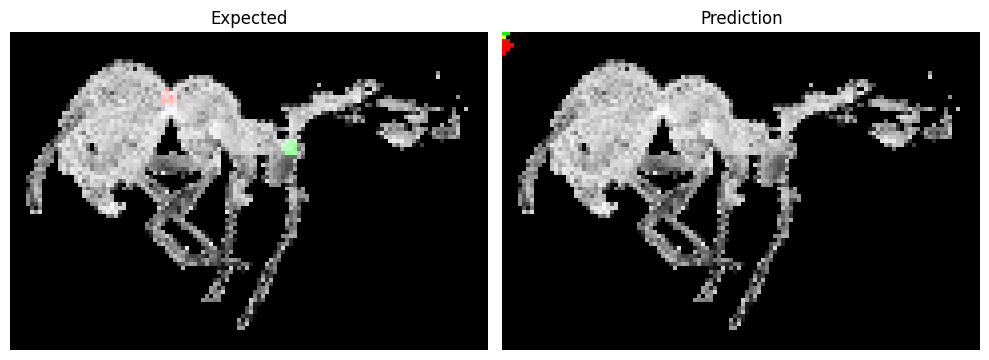

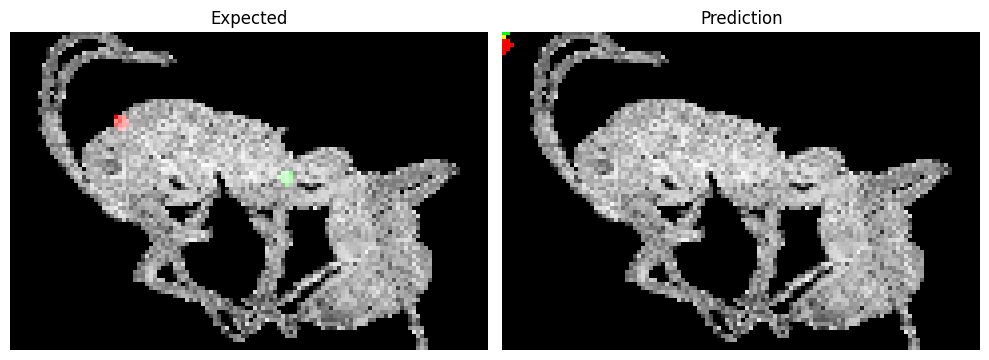

Epoch 50: test loss = 0.006845604162663221, lr = 5.9895600646616125e-05


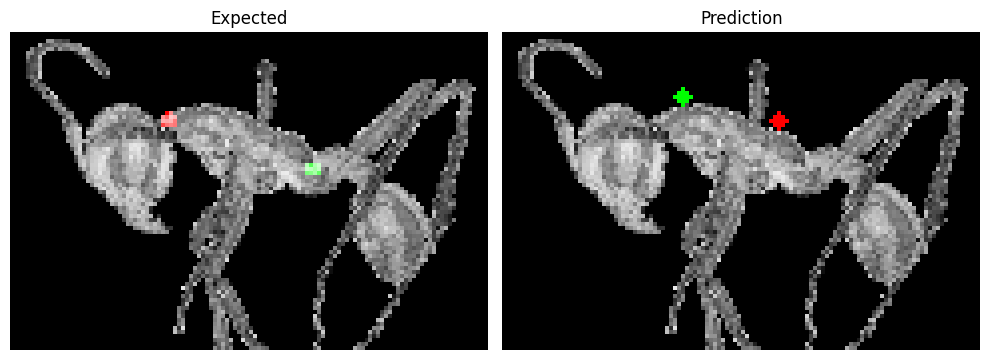

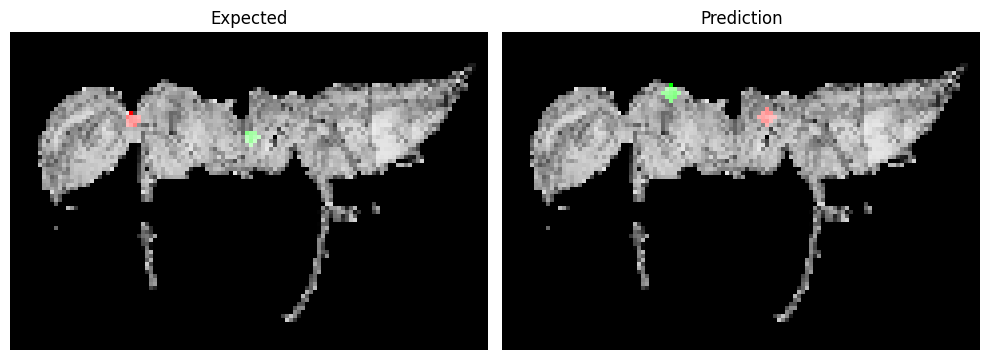

Epoch 100: test loss = 0.00473175011575222, lr = 3.62372017860497e-05


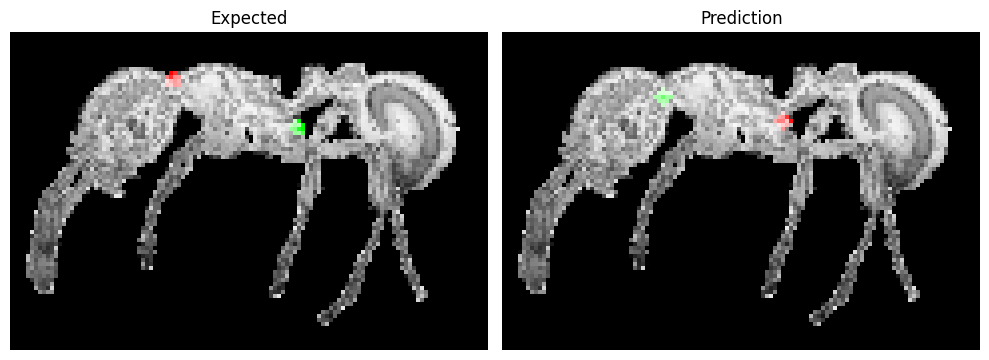

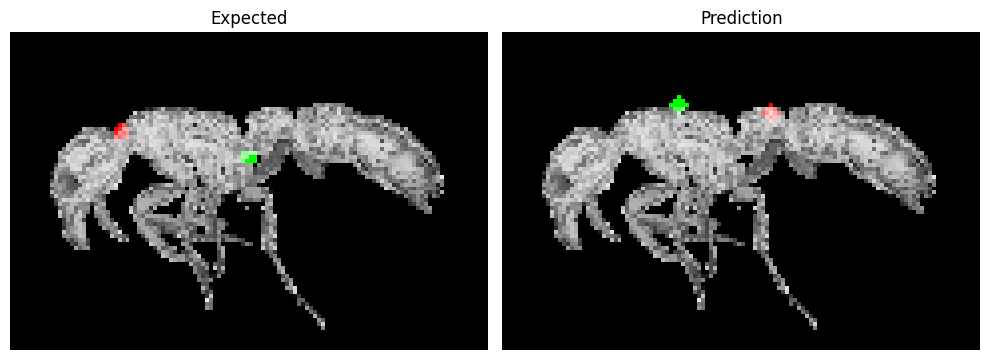

Epoch 150: test loss = 0.0057769217528402805, lr = 2.1923726936647233e-05


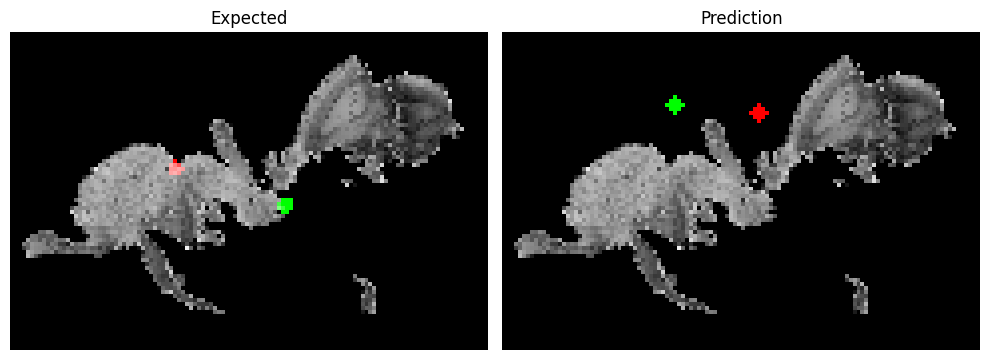

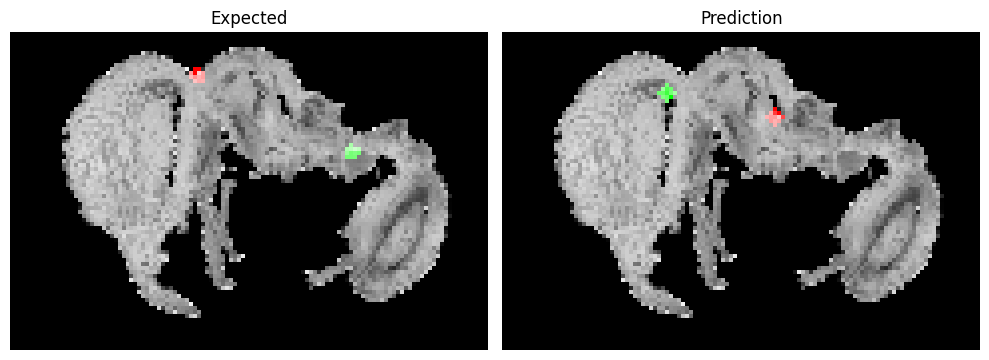

Epoch 200: test loss = 0.003750454168766737, lr = 1.326398781093821e-05


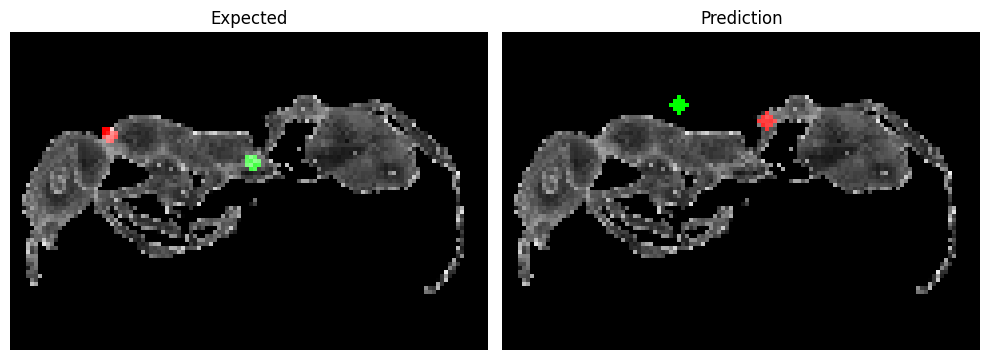

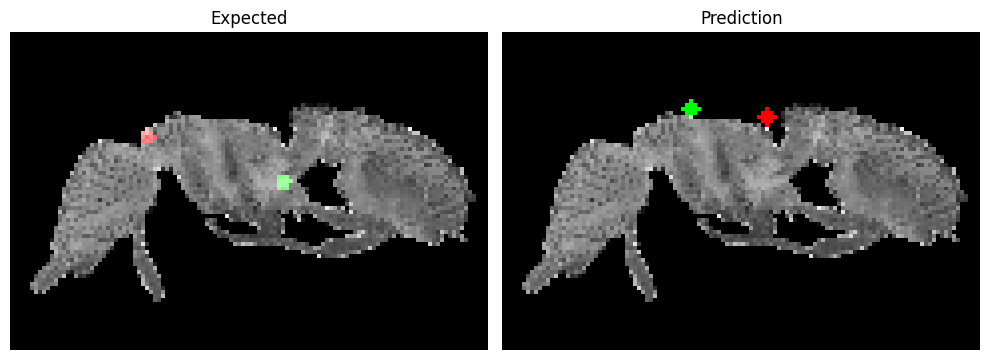

Epoch 250: test loss = 0.0035231439396739006, lr = 8.024793100055947e-06


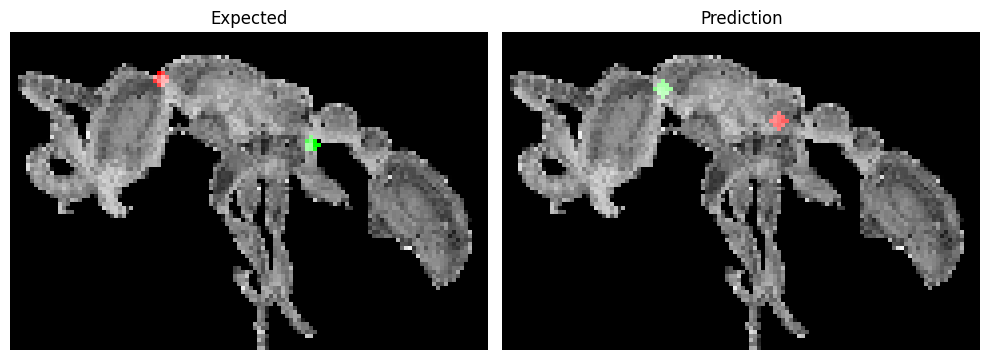

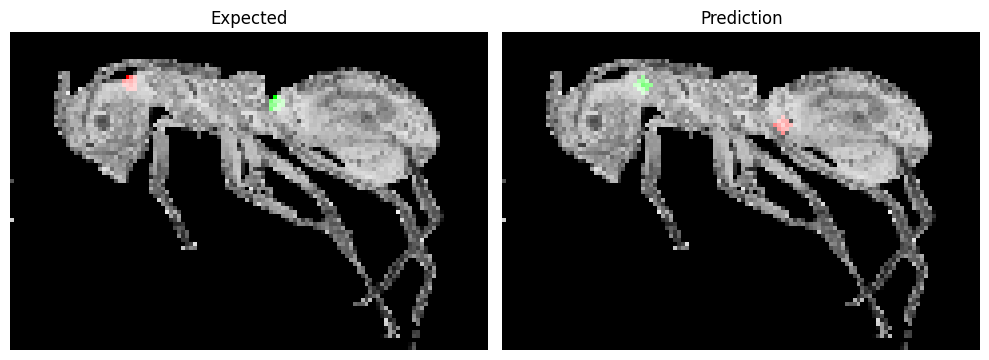

Epoch 300: test loss = 0.0029367010574787855, lr = 4.855048513057286e-06


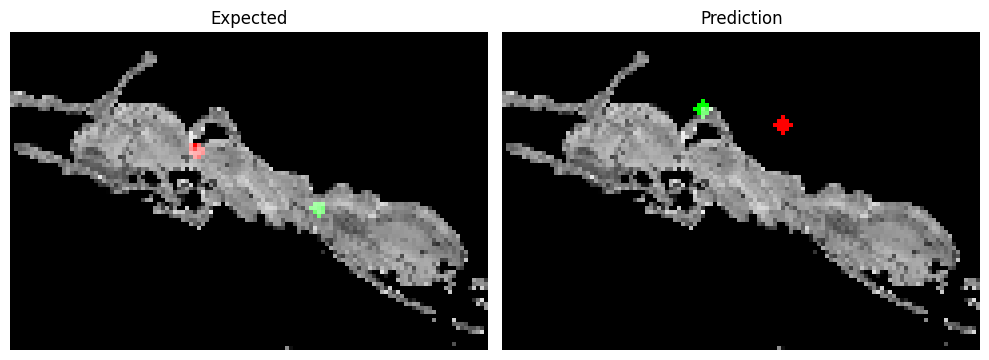

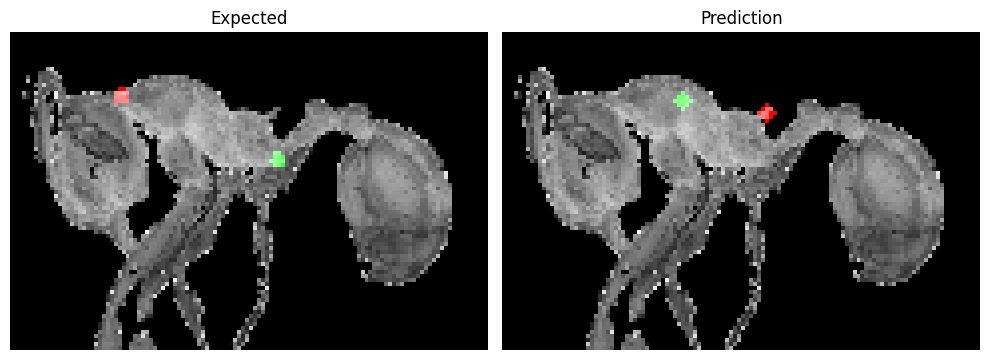

Epoch 350: test loss = 0.003710871795192361, lr = 2.9373338066467324e-06


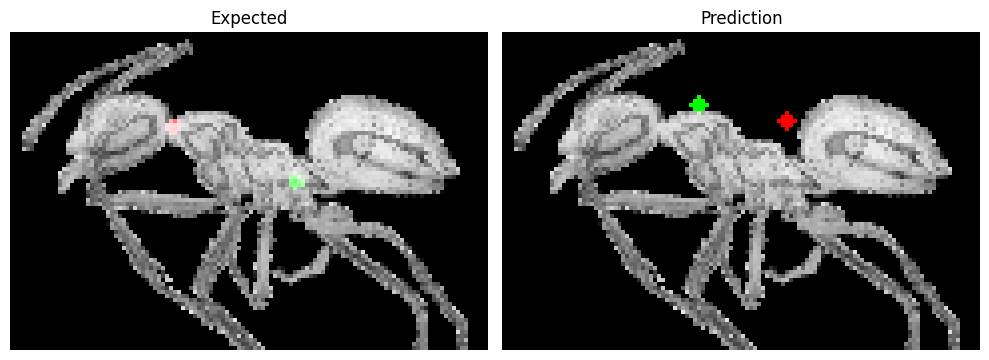

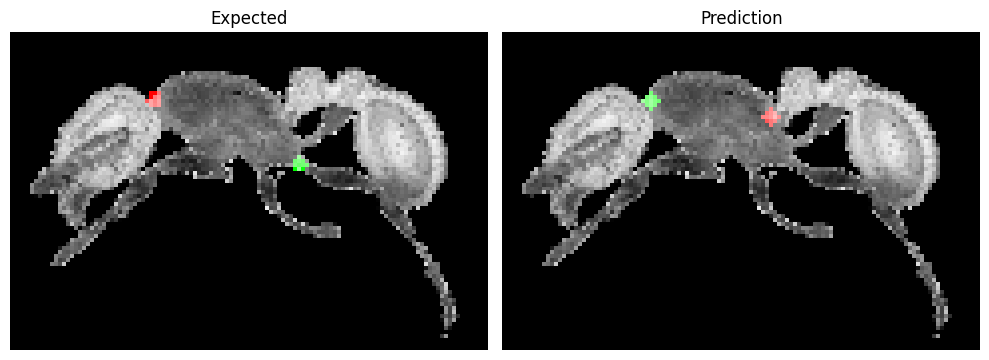

KeyboardInterrupt: 

In [8]:
best_test_loss = 1

kpd_model = model.KeypointDetectionModel().to(device)
batchsize = 50
test_batchsize = 100

criterion = nn.MSELoss()  # Loss for regression
optimizer = torch.optim.Adam(kpd_model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.99)


for epoch in range(500):
    images, keypoints, names = model.get_batch(train_data, batchsize=batchsize, augment_images=False)  
    # Move the data to the MPS device
    images = images.to(device)
    keypoints = keypoints.to(device)
    optimizer.zero_grad()
    outputs = kpd_model(images)  # Forward pass
    loss = criterion(outputs, keypoints)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    scheduler.step() # Update LR 

    if not epoch%50:
        with torch.no_grad():
            kpd_model.eval()
            images, keypoints, names = model.get_batch(test_data, batchsize=test_batchsize, augment_images = False)  
            # Move the data to the MPS device
            images = images.to(device)
            keypoints = keypoints.to(device)
            #optimizer.zero_grad()
            outputs = kpd_model(images)  # Forward pass
            test_loss = criterion(outputs, keypoints)  # Compute loss
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: test loss = {test_loss}, lr = {current_lr}")

            plot_model_prediction(kpd_model, test_data, 2, device="mps", augment_images=False)
            kpd_model.train()
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = kpd_model.state_dict()


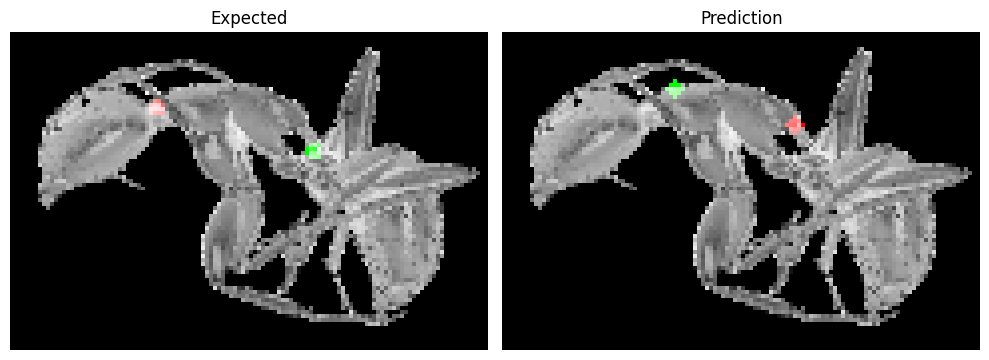

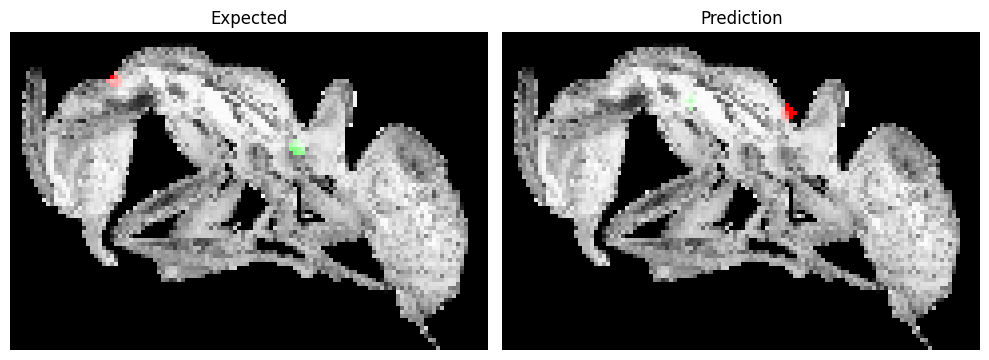

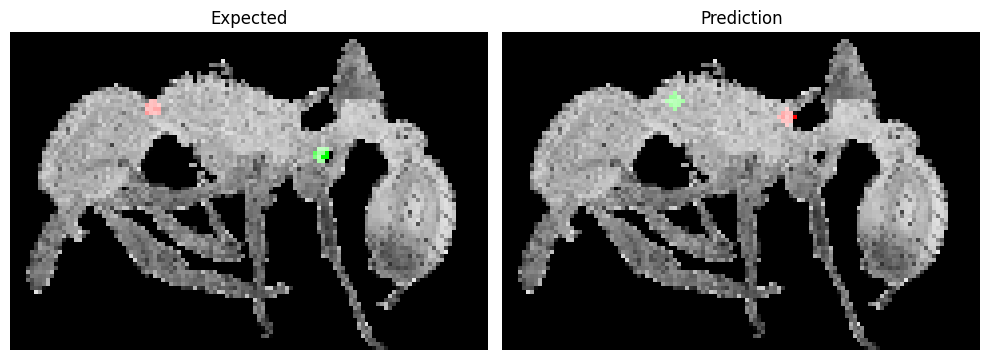

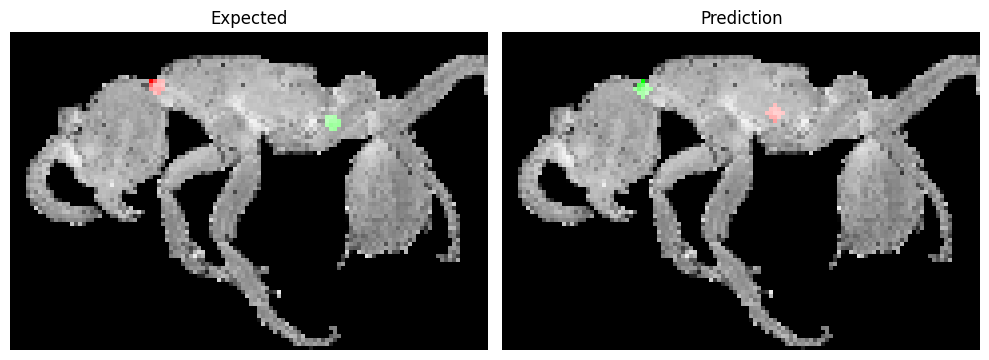

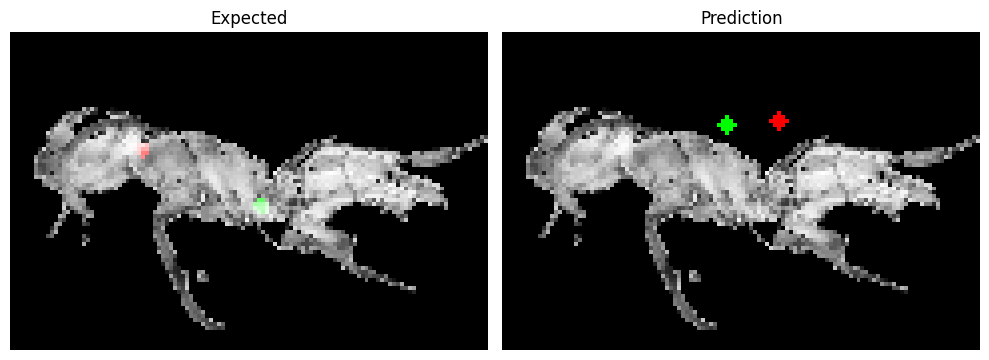

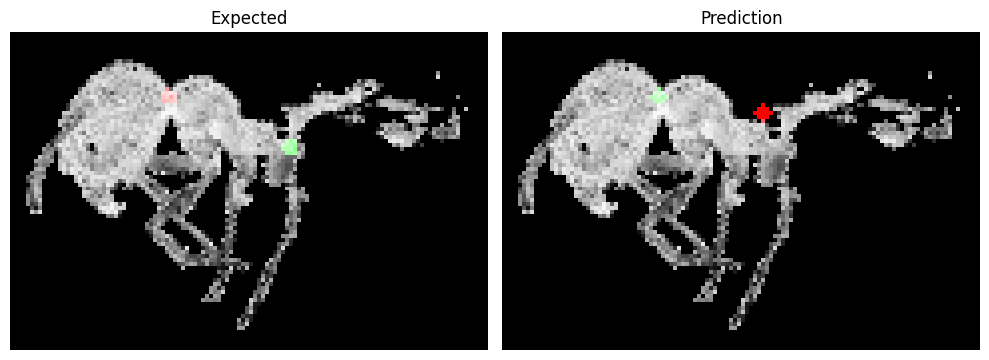

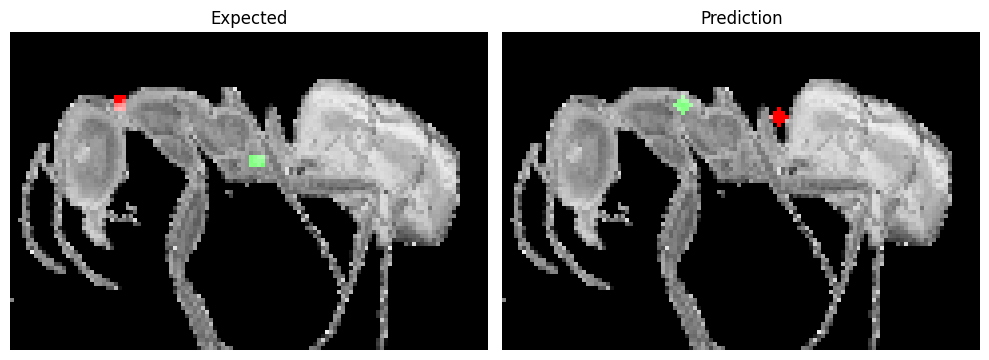

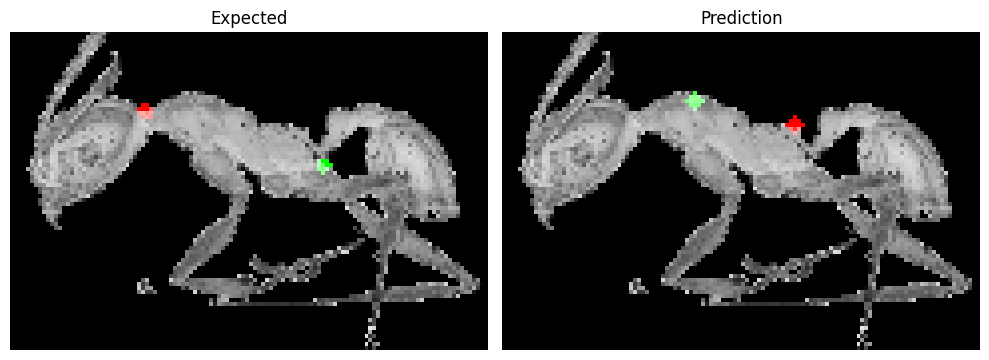

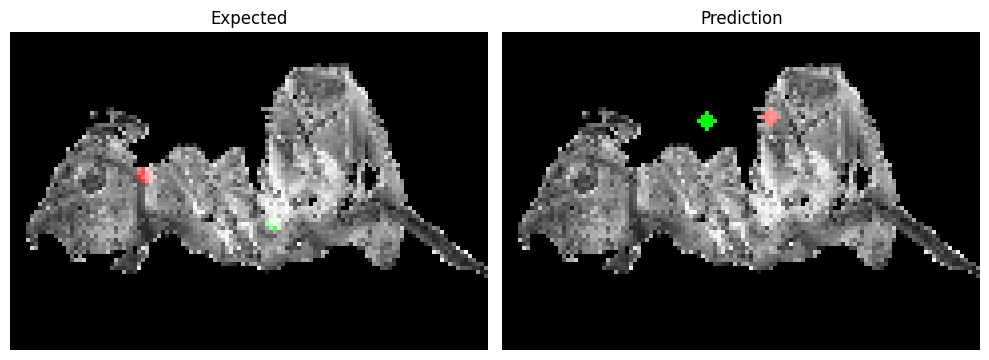

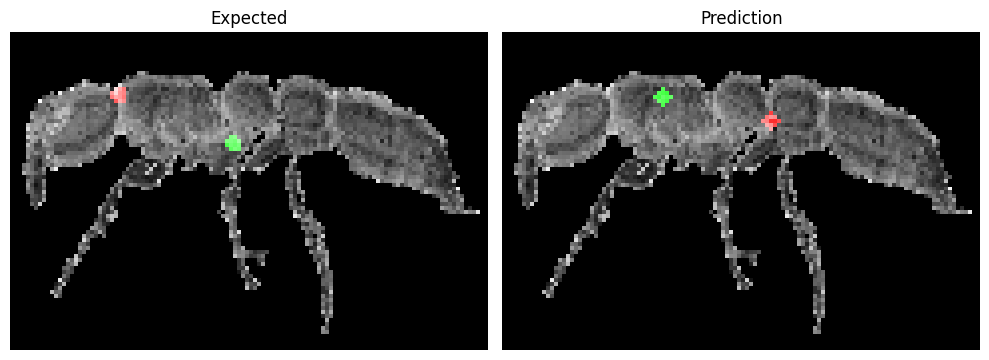

In [9]:
kpd_model.load_state_dict(best_model_state)
"""
Messed up thing number 2:
The two points got exchanged, need to investigate why
"""
plot_model_prediction(kpd_model, test_data, 10, augment_images=False, device=device)

- Use autoencoder ?
- Add head/train second model for confidence

In [17]:
import ConfidenceModel

kpd_model.eval()

conf_best_test_loss = 10

conf_model = ConfidenceModel.ConfidenceModel().to(device)
conf_batchsize = 100
conf_test_batchsize = 100

conf_criterion = nn.MSELoss()  # Loss for regression
conf_optimizer = torch.optim.Adam(conf_model.parameters(), lr=1e-5)

conf_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(conf_optimizer, lr_lambda=lambda epoch: 0.99)

conf_model.train()

for epoch in range(150):
    images, errors, names = ConfidenceModel.get_batch(train_data, kpd_model, batchsize=conf_batchsize, augment_images=False, device = device)  
    # Move the data to the MPS device
    images = images.to(device)
    errors = errors.to(device)
    conf_optimizer.zero_grad()
    outputs = conf_model(images)  # Forward pass
    loss = conf_criterion(outputs, errors)  # Compute loss
    loss.backward()  # Backpropagation
    conf_optimizer.step()  # Update weights
    conf_scheduler.step() # Update LR 

    if not epoch%15:
        with torch.no_grad():
            conf_model.eval()
            images, errors, names = ConfidenceModel.get_batch(test_data, kpd_model, batchsize=conf_test_batchsize, augment_images = False, device = device)  
            # Move the data to the MPS device
            images = images.to(device)
            errors = errors.to(device)
            #optimizer.zero_grad()
            outputs = conf_model(images)  # Forward pass
            test_loss = conf_criterion(outputs, errors)  # Compute loss
            current_lr = conf_optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: test loss = {test_loss}, lr = {current_lr}")

            conf_model.train()
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_conf_model_state = conf_model.state_dict()

Epoch 0: test loss = 0.0006588344112969935, lr = 9.9e-06
Epoch 15: test loss = 9.838811820372939e-05, lr = 8.514577710948753e-06
Epoch 30: test loss = 7.943453238112852e-05, lr = 7.323033696543972e-06
Epoch 45: test loss = 6.365362787619233e-05, lr = 6.29823631203232e-06
Epoch 60: test loss = 6.196038157213479e-05, lr = 5.416850759668533e-06
Epoch 75: test loss = 7.279183137143264e-06, lr = 4.658807751697933e-06


KeyboardInterrupt: 

In [25]:
"""
Plot keypoint detection model prediction side by side with expected keypoints
"""
def plot_conf_model_prediction(kpd_model, data, n_images, conf_model = None, estimated_error_interval = [-1, 1], augment_images = False, device=None):

    # Set model to evaluation mode (disables dropout, batchnorm, etc.)
    kpd_model.eval()

    # Sample n_images images to plot
    for image_data in random.sample(data, n_images):

        # Get image path. All images without bachground for the model are .png, so we need to change the suffix
        name = image_data["Image Name"]
        img_path = os.path.join(Config.images_folder_path + "/", name)
        base, _ = os.path.splitext(img_path)
        img_path = f"{base}.png"

        # Get keypoints
        x1, y1 = image_data["x1"], image_data["y1"]
        x2, y2 = image_data["x2"], image_data["y2"]

        # Prepare image and keypoints for the model
        img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)], augment_images=augment_images)
        x, _ = model.to_xy(img, keypoints)
        # We somehow have to unsqueeze twice, could be worth investigating
        x_tensor = x.unsqueeze(0).unsqueeze(0).to(device)  # Move to the correct device (MPS or CPU)
        
        # Forward pass on the model
        with torch.no_grad():  # No gradients needed for inference
            pred = kpd_model(x_tensor)

        # Post-processing of the model output (e.g., rescale the coords which are outputed between 0 and 1)
        """
        This is completely messed up but somehow we have to switch x and y (it should be x1, y1, x2, y2 = ...)
        Somewhere in the code x and y were already switched, we need to find where...
        """
        y1pred, x1pred, y2pred, x2pred = pred[0][0].item() * Config.input_image_shape[0], pred[0][1].item() * Config.input_image_shape[1], pred[0][2].item() * Config.input_image_shape[0], pred[0][3].item() * Config.input_image_shape[1]

        #img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)])
        
        # If len(keypoints) != 2, then the augmentation lost a keypoint (too much rotation for example) and we are not interested
        if len(keypoints) == 2:

            if conf_model is None:
                display = True
            else:
                conf_model.eval()
                with torch.no_grad():
                    error_pred = conf_model(x_tensor)
                    min_error, max_error = estimated_error_interval[0], estimated_error_interval[1]
                    display = True if (min_error <= error_pred and error_pred <= max_error) else False
            
            if display:
                print("Error estimation = ", error_pred.item())
                
                # Add keypoints and prediction to the image and plot
                with_y = ip.add_point_channels(img, keypoints[0], keypoints[1])
                with_pred = ip.add_point_channels(img, (int(x1pred), int(y1pred)), (int(x2pred), int(y2pred)))

                # Plot side-by-side
                plt.figure(figsize=(10, 5))  # Set the figure size

                # First image
                plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
                plt.imshow(with_y)  # Display the first image
                plt.title("Expected")
                plt.axis('off')  # Turn off axes for better visual effect

                # Second image
                plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
                plt.imshow(with_pred)  # Display the second image
                plt.title("Prediction")
                plt.axis('off')

                # Display the plot
                plt.tight_layout()  # Adjust spacing
                plt.show()

                

Confident predictions:
Error estimation =  0.0018230052664875984


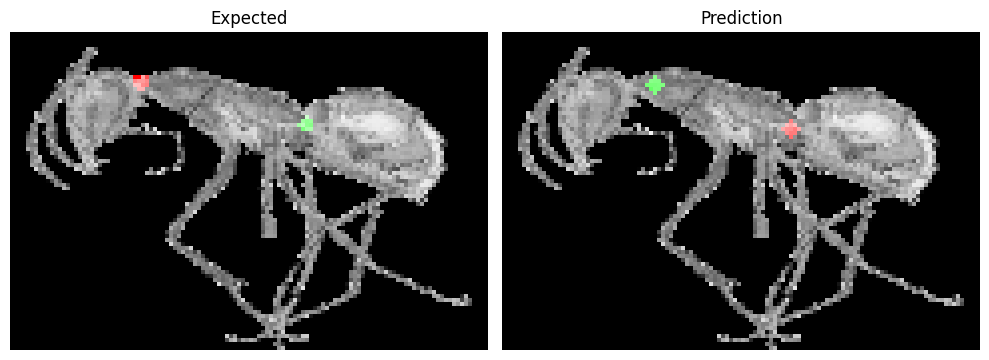

Error estimation =  0.0006660791113972664


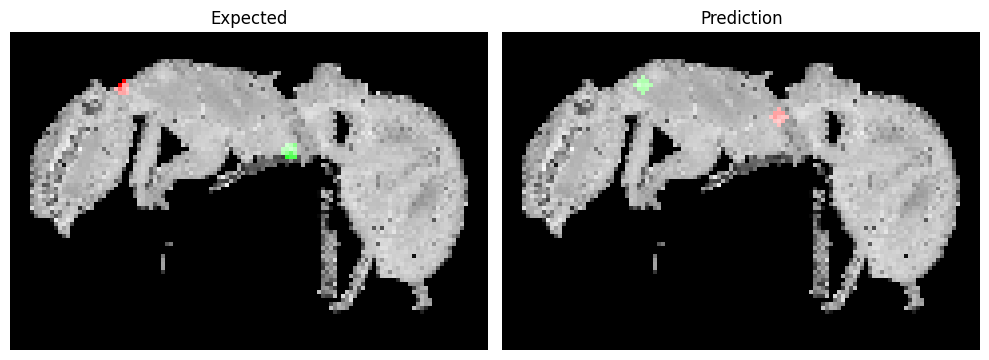

Error estimation =  0.0011569252237677574


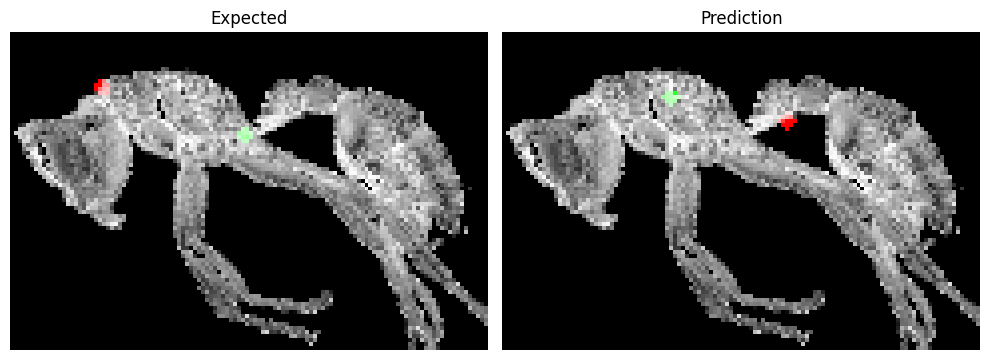

Error estimation =  0.0017065303400158882


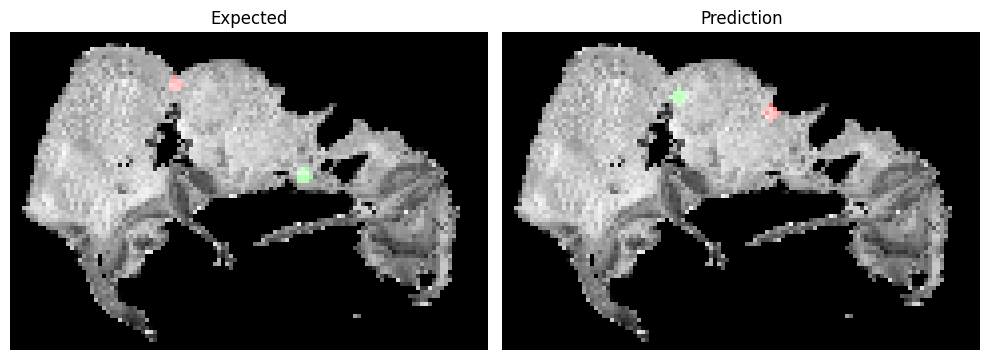

Error estimation =  0.0017987936735153198


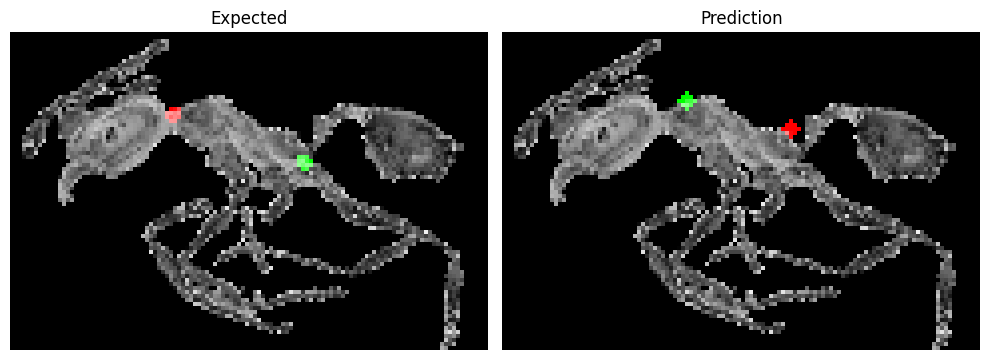

Error estimation =  0.00033570732921361923


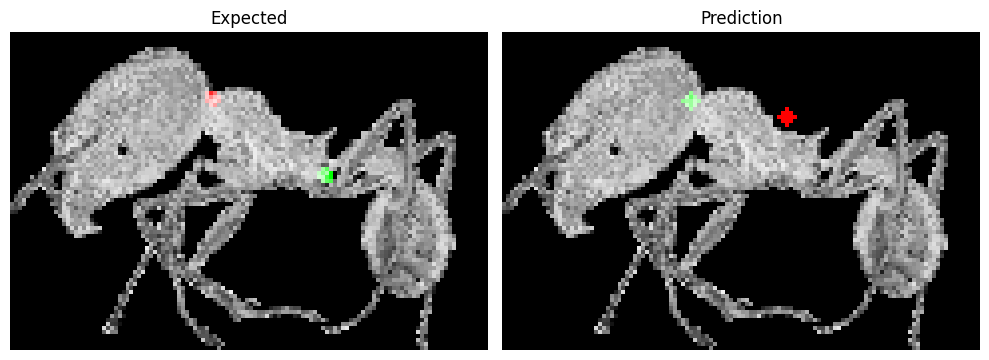

Error estimation =  0.0008021797984838486


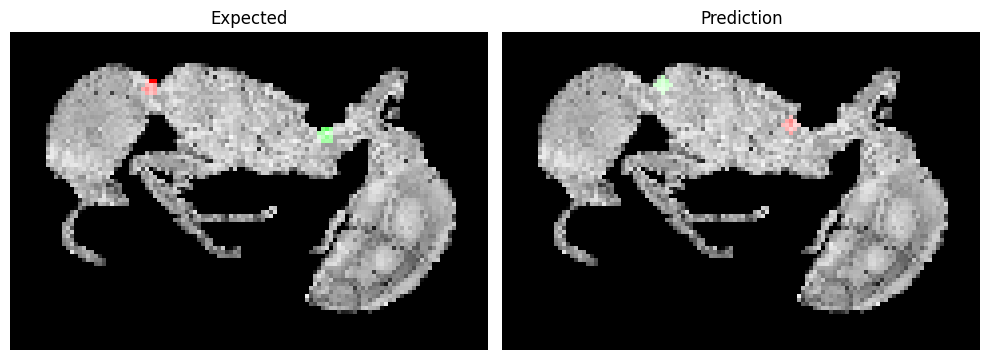

Error estimation =  0.0005341945216059685


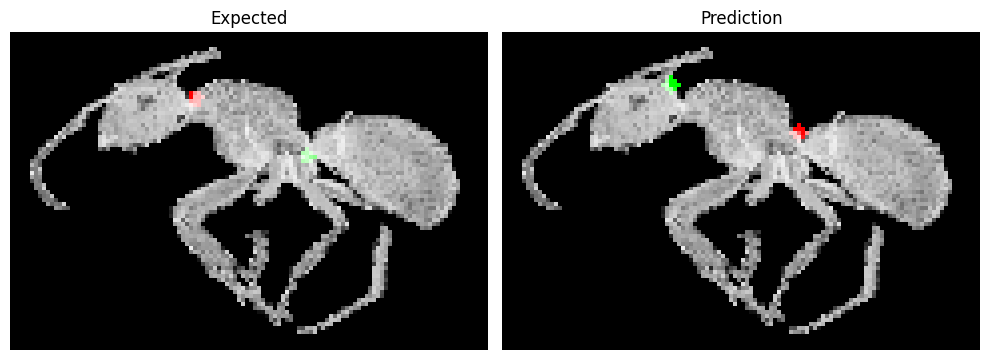

Error estimation =  0.001325228251516819


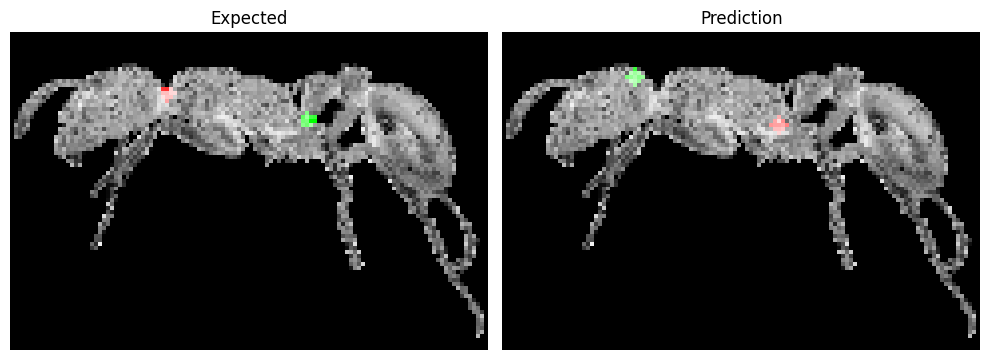

Error estimation =  0.0016421722248196602


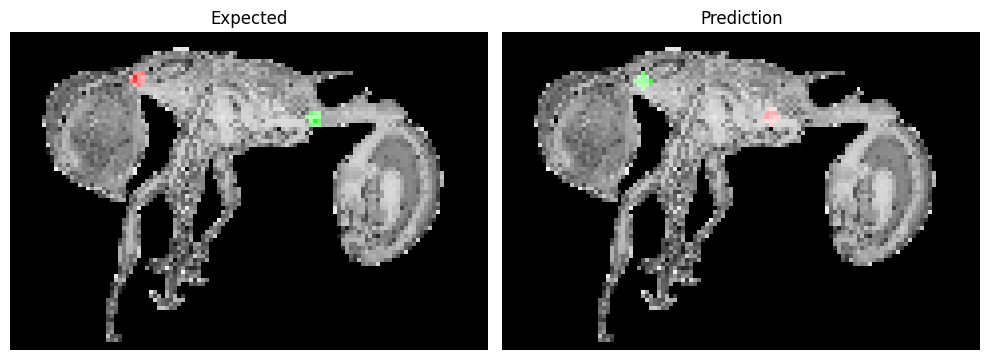

Error estimation =  0.0019150683656334877


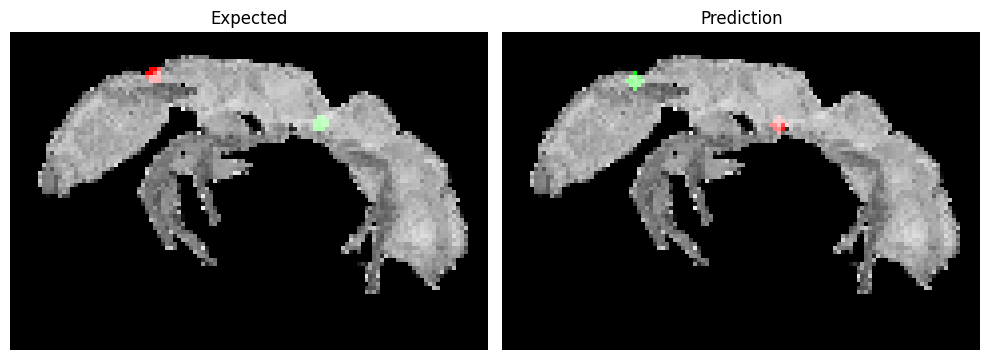

In [26]:
conf_model.load_state_dict(best_conf_model_state)
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
plot_conf_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, estimated_error_interval= [-1, 0.002],augment_images=False, device="mps")

Non-confident predictions:
Error estimation =  0.005946223624050617


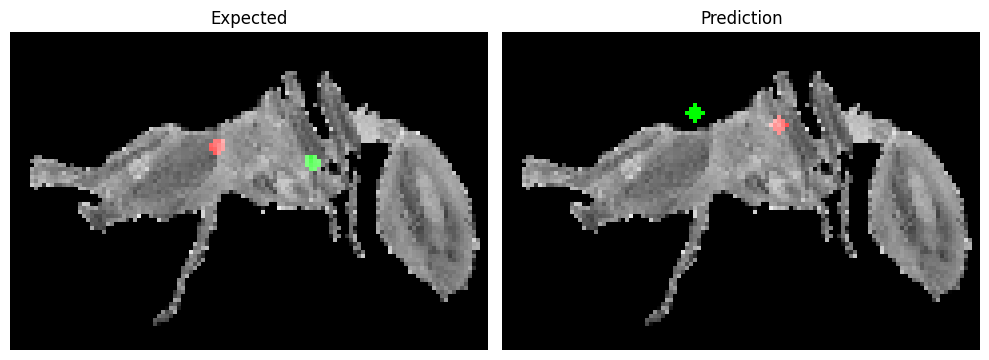

Error estimation =  0.005833766423165798


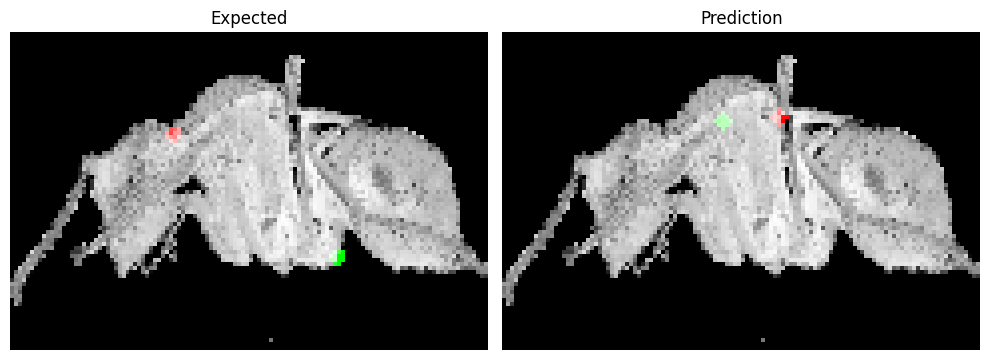

Error estimation =  0.007443576119840145


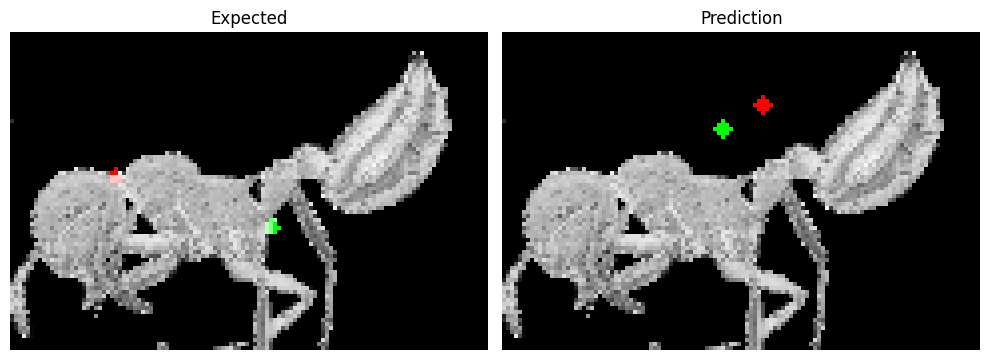

Error estimation =  0.007152733393013477


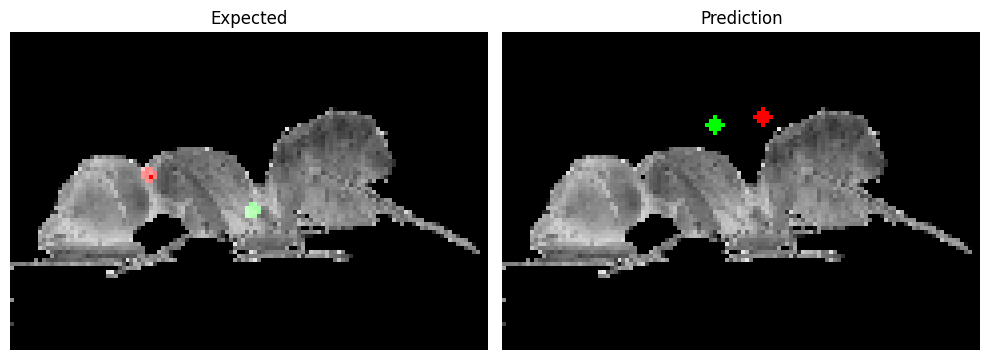

Error estimation =  0.008004619739949703


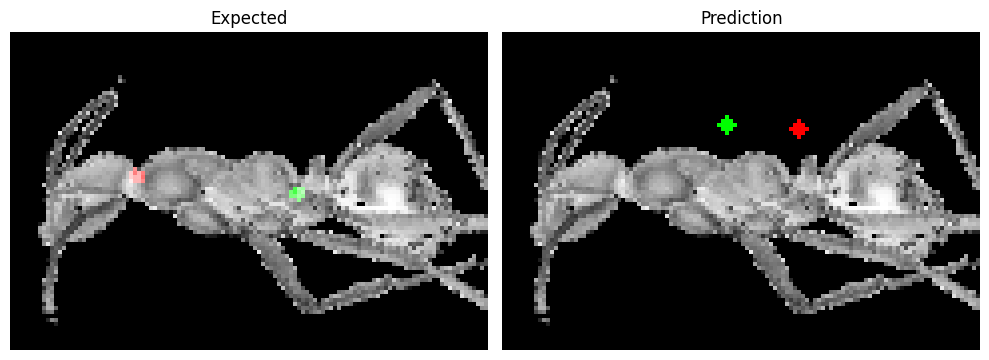

In [27]:
print("Non-confident predictions:")
plot_conf_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, estimated_error_interval= [0.005, 1],augment_images=False, device="mps")